In [1]:
# import all packages needed
import string, copy, math
from typing import Optional, Tuple

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from base64 import b64decode as decode

import torch
import torch.nn as nn 
from torch.nn import CrossEntropyLoss, MSELoss, TransformerEncoder, TransformerEncoderLayer
import torch.nn.functional as F
import torch.fft as fft
from torch.utils.tensorboard import SummaryWriter

from transformers import GPT2Tokenizer, GPT2Config, GPT2PreTrainedModel, GPT2Model, RobertaTokenizer, RobertaPreTrainedModel, RobertaForCausalLM, RobertaModel, RobertaConfig, EncoderDecoderModel
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions, CausalLMOutputWithCrossAttentions

from tokenizers import Tokenizer
from tokenizers.models import BPE, Unigram, WordPiece, WordLevel
from tokenizers.trainers import BpeTrainer, UnigramTrainer, WordPieceTrainer, WordLevelTrainer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# The only time we need to define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Data Processing / Cleaning

In [2]:
# read in data
waveform_data = pd.read_csv("data/10000/waveform-10000.csv")
lead_data = pd.read_csv("data/10000/lead_data-10000.csv")
diagnosis_data = pd.read_csv("data/10000/diagnosis-10000.csv")

lead_data

,lead_data_id,waveform_id,lead_id,lead_byte_count_total,lead_time_offset,waveform_data,lead_sample_count_total,lead_amplitude,lead_data_crc32
0,1,2,4,1200,0,0x0C000C000C000C000C000C000D000E000E000F001000...,600,4.88,1081043306
1,2,2,5,1200,0,0x170017001800180018001A001C001D001F0020002200...,600,4.88,2443089335
2,3,2,6,1200,0,0x580059005C005F006200640066006A006D006F007000...,600,4.88,4278478049
3,4,2,7,1200,0,0x6B006D007000730077007A007C008000830086008700...,600,4.88,1285239324
4,5,2,8,1200,0,0x5D005E006100650068006C006F007200750079007B00...,600,4.88,172911202
...,...,...,...,...,...,...,...,...,...
163367,162505,19892,4,600,0,0x230020001E001B0018001600130011000E000B000A00...,300,4.88,4035603671
163368,162506,19892,5,600,0,0x20001F001C001A001800170016001400130011001000...,300,4.88,356224165
163369,162507,19892,6,600,0,0xE0FFE1FFE3FFE4FFE6FFE8FFE9FFEBFFEDFFEEFFEFFF...,300,4.88,222806952
163370,162508,19892,7,600,0,0xF1FFF1FFF1FFF1FFF4FFF4FFF5FFF6FFF7FFF7FFF8FF...,300,4.88,2876442497


In [3]:
# use class base64 to decode waveform data
def to_array(wf):
    barr = bytearray.fromhex(wf[2:])
    vals = np.array(barr)
    return vals.view(np.int16).astype(np.float32)


# add decoded data as a column to lead dataz
waveforms = list(lead_data['waveform_data'])
lead_data['decoded_waveform'] = [to_array(i) for i in waveforms]

In [4]:
# merge waveform data and lead data
waveform_lead = lead_data.merge(waveform_data, how = "left", left_on = "waveform_id", right_on = "waveform_id", suffixes = (None, None))

# sort by exam id and lead id
waveform_lead.sort_values(by = ["waveform_id", "lead_id"], inplace = True)
waveform_lead = waveform_lead[waveform_lead.lead_sample_count_total == 2500]
waveform_lead = waveform_lead[['exam_id', 'lead_id', 'decoded_waveform']]
print(waveform_lead)

        exam_id  lead_id                                   decoded_waveform
249           8        4  [-9.0, -9.0, -8.0, -8.0, -7.0, -7.0, -7.0, -4....
250           8        5  [-11.0, -10.0, -6.0, -4.0, -1.0, 3.0, 3.0, 5.0...
259           8        6  [4.0, 4.0, 5.0, 7.0, 10.0, 12.0, 12.0, 12.0, 1...
265           8        7  [-7.0, -7.0, -5.0, -3.0, 0.0, 2.0, 3.0, 3.0, 2...
266           8        8  [-21.0, -20.0, -18.0, -14.0, -11.0, -9.0, -8.0...
...         ...      ...                                                ...
162619    10001        7  [-132.0, -136.0, -140.0, -133.0, -126.0, -101....
162620    10001        8  [-274.0, -293.0, -312.0, -297.0, -282.0, -248....
162621    10001       10  [-154.0, -198.0, -242.0, -247.0, -252.0, -224....
162622    10001       12  [72.0, 19.0, -34.0, -71.0, -108.0, -129.0, -15...
162623    10001       13  [112.0, 72.0, 32.0, -2.0, -36.0, -58.0, -80.0,...

[41460 rows x 3 columns]


In [5]:
# merge waveform data and lead data
waveform_lead = lead_data.merge(waveform_data, how = "left", left_on = "waveform_id", right_on = "waveform_id", suffixes = (None, None))

# sort by exam id and lead id
waveform_lead.sort_values(by = ["waveform_id", "lead_id"], inplace = True)

# adding the diagnosis and labels
waveform_and_diag = pd.merge(waveform_lead[['exam_id', 'lead_id', 'decoded_waveform', 'waveform_type_id']], diagnosis_data[["exam_id", "FullText", "original_diagnosis"]], left_on= "exam_id", right_on="exam_id")


# concatenate all leads into a single array
waveform_lead_concat = waveform_lead.groupby(["exam_id", "waveform_type_id"])['decoded_waveform'].apply(lambda x: tuple(x)).reset_index()


# remove irregular observations, concat tuple into numpy array
waveform_lead_concat = waveform_lead_concat[waveform_lead_concat["decoded_waveform"].apply(lambda x: len(x[0]) == 2500)]
waveform_lead_concat = waveform_lead_concat[waveform_lead_concat["decoded_waveform"].apply(lambda x: len(x) == 8)]
   

waveform_lead_concat['decoded_waveform'] = waveform_lead_concat['decoded_waveform'].apply(lambda x: np.vstack(x))
waveform_lead_rhythm = waveform_lead_concat[waveform_lead_concat['waveform_type_id'] == 4]

def drop_nans(ary):
    return np.asarray(ary)[np.logical_not(np.isnan(ary))]

def remove_offset(ary):
    return np.asarray(ary) - np.mean(drop_nans(ary))


def zero_origin(ary):
    return ary - ary[0]


def signalclipper(ary, magnitude = .015):
    return np.clip(ary, magnitude*-1, magnitude)


def ECG_filter(ary, low_cut = .5, high_cut = 30):
    filter_coefs = signal.butter(4, [low_cut,high_cut], 'bp', fs=1000, output='sos') #500hz sample rate
    #ary = remove_offset(ary)
    ary = zero_origin(ary)
    # ary = np.array(clip_intial_time(ary)).reshape(-1)
    ary = drop_nans(ary)
    ary = signal.sosfilt(filter_coefs, ary)
    #ary = signalclipper(ary)
    return ary



def normalize(ary):
    ary = remove_offset(ary)
    ary = ary/np.max(drop_nans(ary))
    return ary

waveform_lead_rhythm["decoded_waveform"] = waveform_lead_rhythm["decoded_waveform"].apply(lambda value: normalize(value))




exams = diagnosis_data["exam_id"].unique()

diagnosis_data = diagnosis_data[diagnosis_data['original_diagnosis'] == 1].dropna()

searchfor = ['previous', 'unconfirmed', 'compared', 'interpretation', 'significant']
diagnosis_data = diagnosis_data.loc[diagnosis_data['FullText'].str.contains('|'.join(searchfor)) != 1]

diagnosis_data.sort_values(by=["exam_id", "statement_number"], inplace=True)
diagnoses = []
curr_id = 0
curr_string = ""


# making the tokens
tokens = set()
done = False
prefixed_phrase = ""
for i, row in diagnosis_data.iterrows():
    if curr_id == 0:
        curr_id = row["exam_id"]
    
    if (row["exam_id"] != curr_id and curr_string != "") or done:        
        if curr_id == row["exam_id"]:
            continue
            
        curr_string = curr_string.lower().replace(" ,", "")
        val = [curr_id, curr_string[:-2]]
        diagnoses.append(val)
        curr_string = ""
        curr_id = row["exam_id"]
        done = False
    
    if "*" in row["FullText"] or "(" in row["FullText"]:
        continue
    
    
    
    if row["FullText"][-4:] == "with" or row["FullText"][-1] == "&":
        prefixed_phrase = row["FullText"].lower() + " "
        curr_string += row["FullText"] + " @"
        continue
    
    
    
    if curr_string and curr_string[-1] == "@":
        curr_string = curr_string[:-1]
        curr_string += row["FullText"] + "; "
    else:
        curr_string += row["FullText"] + "; "
    
    
    tokens.add(prefixed_phrase + row["FullText"].lower().replace(" ,", "").replace(", age", "age"))
    prefixed_phrase = ""
    
    if curr_string[-5:] == "ECG; " or curr_string[-23:] == "ventricular pacemaker; ":
        done = True
    
diagnosis_df = pd.DataFrame(diagnoses, columns = ['exam_id', 'diagnosis'])
waveform_lead_rhythm_diag = pd.merge(left=waveform_lead_rhythm, right=diagnosis_df, left_on='exam_id', right_on='exam_id')



# Define all the data here
tokens = list(tokens)
#full_x = torch.tensor(waveform_lead_rhythm_diag['decoded_waveform']).float().to(device)
#full_y = list(waveform_lead_rhythm_diag['diagnosis'])

In [6]:
class dataLoader():
    def __init__(self, df, batch_size):
        self.df = df.sample(frac=1)
        self.decoded = list(self.df["decoded_waveform"])
        self.diagnoses = list(self.df['diagnosis'])
        
        self.starting_index = 0
        self.cap = len(df)
        self.batch_size = batch_size
    
    def generate(self):
        # generates both x and y
        if self.starting_index + self.batch_size > self.cap:
            output1 = torch.tensor(self.decoded[self.starting_index:]).float()
            output2 = self.diagnoses[self.starting_index:]
            self.starting_index = 0
            self.df = self.df.sample(frac=1)
            self.decoded = list(self.df["decoded_waveform"])
            self.diagnoses = list(self.df['diagnosis'])
            
        else:
            output1 = torch.tensor(self.decoded[self.starting_index:self.starting_index+self.batch_size]).float()
            output2 = self.diagnoses[self.starting_index:self.starting_index+self.batch_size]
            self.starting_index += self.batch_size
        
        
        return output1, output2

loader = dataLoader(waveform_lead_rhythm_diag, 12)

In [10]:
tokenizer(loader.generate()[1])

{'input_ids': tensor([[  0, 148,  32, 169,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0, 121, 140,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0, 121, 140,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0, 121,  21,  76,  84,  25,   0,   0,   0,   0,   0,   0,   0],
         [  0, 148, 157,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0, 121,  71,  21, 146, 124,  28,  19,   0,   0,   0,   0,   0],
         [  0,  30, 157,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0, 148, 157,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0, 136,  34,  72,  25,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0, 121, 140,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0, 121, 140,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0, 121,  32,   6,  26,  25,   0,   0,   0,   0,   0,   0,   0]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
     

# Tokenizers

In [7]:
# Creating and pretraining tokenizer for the LSTM Encoder-Decoder model

class tokenizer(nn.Module):
    def __init__(self, vocab, max_len=12):
        super(tokenizer, self).__init__()
        self.tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
        self.trainer = WordLevelTrainer(special_tokens=["[PAD]", "[UNK]"])
        self.tokenizer.train_from_iterator(np.array(tokens), self.trainer)
        self.max_len = max_len
        
    def forward(self, x):
        # expects list of sentence fragments, within each sentence separated by ;
        input_ids = []
        attention_masks = []
        for sentence in x:
            tokenized = self.tokenizer.encode(sentence.split("; "), is_pretokenized=True)
            input_id = [0] + tokenized.ids + [0 for i in range(self.max_len - len(tokenized.ids))]
            attention_mask = [1] + tokenized.attention_mask + [1] + [0 for i in range(self.max_len - len(tokenized.attention_mask) - 1)]
            input_ids.append(input_id)
            attention_masks.append(attention_mask)
        return {"input_ids": torch.tensor(input_ids).detach(), "attention_mask": torch.tensor(attention_masks).detach()}
    
    def forward_lstm(self, x):
        # expects list of sentence fragments, within each sentence separated by ; length is variable
        x = copy.deepcopy(x)
        for i, sentence in enumerate(x):
            x[i] = sentence.split("; ")
        
        output = [self.tokenizer.encode(label, is_pretokenized=True).ids for label in x]
        for i in output:
            i.append(0)
        return output
    
    
    def decode(self, x):
        # expects tensor of ids for a single label
        return self.tokenizer.decode(list(x))

    
tokenizer = tokenizer(vocab=tokens) 
print(len(tokenizer.tokenizer.get_vocab()))
tokenizer.tokenizer.get_vocab()


183


{'anterior infarct': 125,
 'indeterminate axis': 104,
 'or digitalis effect': 8,
 'nonspecific t wave abnormality': 92,
 'wide qrs tachycardia': 14,
 'incomplete left bundle branch block': 165,
 'ventricular pre-excitation, wpw pattern type b': 135,
 'biventricular hypertrophy': 33,
 'junctional st depression, probably abnormal': 66,
 't wave abnormality, consider inferior ischemia': 57,
 'normal sinus rhythm': 87,
 'marked t wave abnormality, consider lateral ischemia': 146,
 'atrial-paced complexes': 116,
 'left bundle branch block': 36,
 'lateral leads': 54,
 'minimal voltage criteria for lvh, may be normal variant': 70,
 'left ventricular hypertrophy': 80,
 'with premature ventricular or aberrantly conducted complexes': 89,
 'marked t wave abnormality, consider inferior ischemia': 16,
 'deep q-wave in lead v6,': 88,
 ', new': 91,
 'atrial fibrillation': 97,
 'st depression, consider subendocardial injury': 19,
 'otherwise normal ecg': 98,
 't wave abnormality, consider inferolatera

### LSTM Tokenizer

In [19]:
# Making labels for the LSTM model
token_y_lstm = tokenizer.forward_lstm(full_y)
token_y_lstm

[[50, 40, 0],
 [55, 53, 0],
 [55, 53, 0],
 [36, 41, 40, 0],
 [55, 47, 32, 60, 3, 5, 0],
 [55, 13, 17, 5, 0],
 [36, 41, 40, 0],
 [55, 56, 21, 8, 10, 0],
 [55, 53, 0],
 [4, 2, 12, 60, 3, 6, 5, 0],
 [24, 30, 37, 19, 23, 5, 0],
 [44, 19, 5, 0],
 [44, 56, 38, 49, 5, 0],
 [55, 53, 0],
 [29, 43, 12, 63, 27, 5, 0],
 [55, 53, 0],
 [24, 2, 12, 57, 3, 5, 0],
 [4, 54, 61, 34, 18, 19, 32, 60, 3, 45, 5, 0],
 [4, 54, 61, 19, 45, 5, 0],
 [20, 42, 0],
 [20, 0],
 [55, 53, 0],
 [55, 53, 0],
 [55, 53, 0],
 [55, 32, 7, 3, 5, 0],
 [55, 53, 0],
 [55, 56, 21, 25, 10, 0],
 [55, 53, 0],
 [55, 53, 0],
 [50, 0],
 [36, 41, 40, 0],
 [55, 31, 10, 0],
 [55, 53, 0],
 [50, 40, 0],
 [4, 32, 7, 3, 5, 0],
 [55, 53, 0],
 [55, 53, 0],
 [55, 53, 0],
 [55, 60, 3, 5, 0],
 [42, 0],
 [55, 60, 3, 5, 0],
 [55, 56, 7, 5, 0],
 [55, 53, 0],
 [55, 53, 0],
 [55, 60, 17, 5, 0],
 [55, 53, 0],
 [55, 53, 0],
 [55, 60, 17, 5, 0],
 [55, 33, 5, 0],
 [55, 53, 0],
 [42, 0],
 [36, 41, 40, 0]]

### Transformer Tokenizer

In [20]:
# Making labels for the transformer model
token_y_transformer = tokenizer(full_y)
token_y_transformer

{'input_ids': tensor([[ 0, 50, 40,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0, 55, 53,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0, 55, 53,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0, 36, 41, 40,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0, 55, 47, 32, 60,  3,  5,  0,  0,  0,  0,  0,  0],
         [ 0, 55, 13, 17,  5,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0, 36, 41, 40,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0, 55, 56, 21,  8, 10,  0,  0,  0,  0,  0,  0,  0],
         [ 0, 55, 53,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  4,  2, 12, 60,  3,  6,  5,  0,  0,  0,  0,  0],
         [ 0, 24, 30, 37, 19, 23,  5,  0,  0,  0,  0,  0,  0],
         [ 0, 44, 19,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0, 44, 56, 38, 49,  5,  0,  0,  0,  0,  0,  0,  0],
         [ 0, 55, 53,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0, 29, 43, 12, 63, 27,  5,  0,  0,  0,  0,  0,  0],
         [ 0, 55, 53,  0,  0,  0,  0,  0, 

## Embedder: Conv1D

In [8]:
# Tools to help with the creation of an Embedder

# define global max pooling
class global_max_pooling_1d(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        x, _ = torch.max(x, dim = 2)
        return(x)

# define resblock for neural nets
class ResBlock1D(nn.Module):
    def __init__(self, num_filters, kernel_size, padding, groups = 1, stride = 1):
        super(ResBlock1D, self).__init__()
        self.act = nn.ReLU()
        self.conv1d_1 = nn.Conv1d(num_filters, num_filters, kernel_size = kernel_size, padding = padding, groups = groups, stride = stride)
        self.conv1d_2 = nn.Conv1d(num_filters, num_filters, kernel_size = kernel_size, padding = padding, groups = groups, stride = stride)
        self.batch_norm_1 = nn.BatchNorm1d(num_filters)
        self.batch_norm_2 = nn.BatchNorm1d(num_filters)

    def forward(self, x):
        res = x
        x = self.batch_norm_1(self.act(self.conv1d_1(x)))
        x = self.batch_norm_2(self.act(self.conv1d_2(x)))
        return x + res

def init_weights(x):
    if isinstance(x, nn.Conv1d):
        nn.init.kaiming_uniform_(x.weight, mode='fan_in', nonlinearity='relu')
        x.bias.data.fill_(0.01)  

In [9]:
# Connect an embedder and de-embedder for training (we will then isolate the Encoder portion of this autoencoder as our embedder)
class ConvAutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(ConvAutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def make_encoder(self):
        return self.encoder
    
    def make_decoder(self):
        return self.decoder    

## Embedder 1: Conv (AutoEncoder)

In [139]:
# HYPERPARAMETERS
J = 10 # max number of filters per class
LR = 1e-3

NUM_LAYERS = 5
STRIDE = 1
LR = 1e-3
KER_SIZE = 249
PADDING = 124
EMBED_DIM = 256
NUM_LEADS = 8


# build resnet model and display the shape of feed through
conv_model = nn.Sequential()
init_channels = NUM_LEADS
for i in range(NUM_LAYERS):
    next_channels = 2 * init_channels
    conv_model.add_module('conv_{num}'.format(num = i), nn.Conv1d(in_channels = init_channels, out_channels = next_channels, kernel_size = KER_SIZE, padding = PADDING, stride = STRIDE))
    conv_model.add_module('act_{num}'.format(num = i), nn.ELU())
    conv_model.add_module('batch_norm_{num}'.format(num = i), nn.BatchNorm1d(next_channels))
    conv_model.add_module('res_{num}'.format(num = i), ResBlock1D(num_filters = next_channels, kernel_size = KER_SIZE, padding = PADDING))
    conv_model.add_module('act_res_{num}'.format(num = i), nn.ELU())
    init_channels = next_channels
    
conv_model.add_module('conv_fin', nn.Conv1d(in_channels = init_channels, out_channels = EMBED_DIM, kernel_size = KER_SIZE, padding = PADDING))
conv_model.add_module('act_fin', nn.ELU())
conv_model.add_module('batch_fin', nn.BatchNorm1d(EMBED_DIM))
conv_model.apply(init_weights)


# Make de-embedder
deconv_model = nn.Sequential()
init_channels = EMBED_DIM
for i in range(NUM_LAYERS):
    next_channels = init_channels // 2
    deconv_model.add_module('conv_{num}'.format(num = i), nn.ConvTranspose1d(in_channels = init_channels, out_channels = next_channels, kernel_size = KER_SIZE, padding = PADDING, stride = STRIDE))
    deconv_model.add_module('act_{num}'.format(num = i), nn.ELU())
    deconv_model.add_module('batch_norm_{num}'.format(num = i), nn.BatchNorm1d(next_channels))
    deconv_model.add_module('res_{num}'.format(num = i), ResBlock1D(num_filters = next_channels, kernel_size = KER_SIZE, padding = PADDING))
    deconv_model.add_module('act_res_{num}'.format(num = i), nn.ELU())
    init_channels = next_channels
deconv_model.add_module('conv_fin', nn.ConvTranspose1d(in_channels = init_channels, out_channels = NUM_LEADS, kernel_size = KER_SIZE, padding = PADDING))
deconv_model.add_module('act_fin', nn.ELU())
deconv_model.add_module('batch_fin', nn.BatchNorm1d(NUM_LEADS))


class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.KER_SIZE = 9
        self.PADDING = 4
        self.STRIDE = 5
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
    
    
    def build_encoder(self):
        encoder = nn.Sequential()
        init_channels = 8
        KER_SIZE, PADDING, STRIDE = self.KER_SIZE, self.PADDING, self.STRIDE
        for i in range(4):
            next_channels = 3 * init_channels
            encoder.add_module('conv_{num}'.format(num = i), nn.Conv1d(in_channels = init_channels, out_channels = next_channels, kernel_size = KER_SIZE, padding = PADDING, stride = STRIDE))
            encoder.add_module('act_{num}'.format(num = i), nn.ELU())
            encoder.add_module('batch_norm_{num}'.format(num = i), nn.BatchNorm1d(next_channels))
            encoder.add_module('res_{num}'.format(num = i), ResBlock1D(num_filters = next_channels, kernel_size = KER_SIZE, padding = PADDING))
            encoder.add_module('act_res_{num}'.format(num = i), nn.ELU())
            init_channels = next_channels
        
        encoder.add_module('flattener', nn.Flatten())
        encoder.add_module("linear", nn.Linear(2592, 648)) 
        encoder.add_module('act_{num}'.format(num = i+1), nn.ELU())
        #encoder.add_module('batch_norm_{num}'.format(num = i+1), nn.BatchNorm1d(num_features = 648))
        encoder.add_module("linear2", nn.Linear(648, 64)) 
        return encoder
    
    
    
    def build_decoder(self):
        KER_SIZE, PADDING, STRIDE = self.STRIDE, 0, self.STRIDE
        
        decoder = nn.Sequential()
        init_channels = 648
        decoder.add_module("linear", nn.Linear(64, 648))
        decoder.add_module('act_-1', nn.ELU())
        #decoder.add_module('batch_norm_-1', nn.BatchNorm1d(648))
        decoder.add_module("linear2", nn.Linear(648, 2592)) 
        decoder.add_module("reshape", Reshape(-1, 648, 4))
        decoder.add_module('act_-2', nn.ELU())
        #decoder.add_module('batch_norm_-2', nn.BatchNorm1d(648))
        
        for i in range(4):
            next_channels = init_channels // 3
            decoder.add_module('conv_{num}'.format(num = i), nn.ConvTranspose1d(in_channels = init_channels, out_channels = next_channels, kernel_size = KER_SIZE, padding = PADDING, stride = STRIDE))
            decoder.add_module('act_{num}'.format(num = i), nn.ELU())
            decoder.add_module('batch_norm_{num}'.format(num = i), nn.BatchNorm1d(next_channels))
            decoder.add_module('res_{num}'.format(num = i), ResBlock1D(num_filters = next_channels, kernel_size = self.KER_SIZE, padding = self.PADDING))
            decoder.add_module('act_res_{num}'.format(num = i), nn.ELU())
            init_channels = next_channels
        #decoder.add_module('conv_fin', nn.ConvTranspose1d(in_channels = init_channels, out_channels = 8, kernel_size = KER_SIZE, padding = PADDING))
        #decoder.add_module('act_fin', nn.ELU())
        #decoder.add_module('batch_fin', nn.BatchNorm1d(NUM_LEADS))
        #decoder.add_module("linear", nn.Linear(2188, 2500))
        
        return decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def make_encoder(self):
        return self.encoder
    
    def make_decoder(self):
        return self.decoder    

    
encoder = ConvModel().make_encoder()
decoder = ConvModel().make_decoder()

inp = loader.generate()[0][:1]

print(inp.shape)
x = encoder(inp)
print(x.shape)
x = decoder(x)
print(x.shape)


torch.Size([1, 8, 2500])
torch.Size([1, 64])
torch.Size([1, 8, 2500])


In [142]:
# Optional AutoEncoder Pretraining of the Embedder

# Training Params
#auto_model = ConvModel().to(device)
auto_optimizer = torch.optim.Adam(auto_model.parameters(), lr = 1e-4)
torch.autograd.set_detect_anomaly(True)
loss_function = nn.MSELoss()

# Set this to a non-zero number for pretraining

epochs = 100
#full_x, output = loader.generate()
for i in range(epochs):
    auto_optimizer.zero_grad()
    outputs = auto_model(full_x)
    loss = loss_function(outputs, full_x)
    loss.backward(retain_graph=True)
    auto_optimizer.step()
    print(loss)
        
# Saving/loading weights
torch.save(auto_model.state_dict(), 'model/autoencoder.pt')
auto_model.load_state_dict(torch.load('model/autoencoder.pt'))

# Embedder for our other models
conv_embedder = auto_model.make_encoder()

# If powerful enough, then can freeze weights
if epochs > 100:
    for param in conv_embedder.params():
        param.requires_grad = False

torch.save(conv_embedder.state_dict(), "model/embedder.pt")

tensor(0.0265, grad_fn=<MseLossBackward>)
tensor(0.0295, grad_fn=<MseLossBackward>)
tensor(0.0266, grad_fn=<MseLossBackward>)
tensor(0.0274, grad_fn=<MseLossBackward>)
tensor(0.0271, grad_fn=<MseLossBackward>)
tensor(0.0266, grad_fn=<MseLossBackward>)
tensor(0.0262, grad_fn=<MseLossBackward>)
tensor(0.0259, grad_fn=<MseLossBackward>)
tensor(0.0258, grad_fn=<MseLossBackward>)
tensor(0.0256, grad_fn=<MseLossBackward>)
tensor(0.0255, grad_fn=<MseLossBackward>)
tensor(0.0253, grad_fn=<MseLossBackward>)
tensor(0.0252, grad_fn=<MseLossBackward>)
tensor(0.0251, grad_fn=<MseLossBackward>)
tensor(0.0249, grad_fn=<MseLossBackward>)
tensor(0.0247, grad_fn=<MseLossBackward>)
tensor(0.0245, grad_fn=<MseLossBackward>)
tensor(0.0244, grad_fn=<MseLossBackward>)
tensor(0.0243, grad_fn=<MseLossBackward>)
tensor(0.0242, grad_fn=<MseLossBackward>)
tensor(0.0240, grad_fn=<MseLossBackward>)
tensor(0.0239, grad_fn=<MseLossBackward>)
tensor(0.0238, grad_fn=<MseLossBackward>)
tensor(0.0237, grad_fn=<MseLossBac

tensor([[[ 0.0878,  0.0878,  0.0878,  ..., -0.2754, -0.2665, -0.2665],
         [ 0.1409,  0.1409,  0.1409,  ...,  0.3092,  0.3180,  0.3180],
         [-0.0717, -0.0628, -0.0540,  ...,  0.0700,  0.0612,  0.0612],
         ...,
         [ 0.5306,  0.5306,  0.5306,  ...,  0.3269,  0.3446,  0.3446],
         [ 0.1586,  0.1586,  0.1586,  ...,  0.2826,  0.2915,  0.2915],
         [-0.0362, -0.0362, -0.0362,  ..., -0.1691, -0.1425, -0.1425]]])
torch.Size([1, 8, 2500])


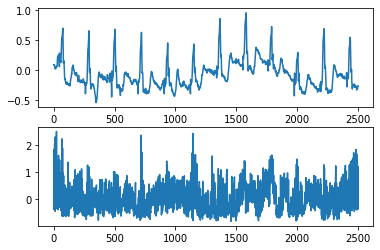

In [151]:
x = full_x[:1]
encoder = auto_model.make_encoder()
print(x)
print(auto_model(x).shape)

y_vals = auto_model(x)[0][0].detach().numpy()
fig, axs = plt.subplots(2)
axs[0].plot(np.arange(2500), x[0][0])
axs[1].plot(np.arange(2500), y_vals)
plt.show()

## Embedder 2: Window Embedder

In [8]:
class WindowEmbedder(nn.Module):
    def __init__(self, slice_size=25, embed_dim=512, num_leads=8):
        super(WindowEmbedder, self).__init__()
        self.slice_size = slice_size # should divide 2500
        self.embed_dim = embed_dim
        self.num_leads = num_leads
        self.linear = nn.Linear(slice_size * num_leads, embed_dim)
        
    def forward(self, x):
        # assumes the input is batch, then embed_dim, then seq_length
        if len(x.shape) == 2: # when input is 1 by 1
            x = x.unsqueeze(0)
        flattened_slice_length = self.slice_size * self.num_leads
        x = x.transpose(2, 1)
        x = x.contiguous().view(-1, 2500 // self.slice_size, flattened_slice_length)
        x = self.linear(x).transpose(1, 0)
        return x
    
    def forward_no_lin(self, x):
        if len(x.shape) == 2: # when input is 1 by 1
            x = x.unsqueeze(0)
        flattened_slice_length = self.slice_size * self.num_leads
        x = x.transpose(2, 1)
        x = x.contiguous().view(-1, 2500 // self.slice_size, flattened_slice_length)
        return x


## LSTM Encoder-Decoder Model

In [6]:
# define hyperparameters 
hidden_layers = 1024
embedding_dim = EMBED_DIM
word_list_length = 65
start_token = end_token = 0
seq_length = 13

class Global_Dot_Attention(nn.Module):
    def __init__(self, enc_h, dec_h):
        super(Global_Dot_Attention, self).__init__()
        self.h_dim = dec_h
        self.linear_out = nn.Linear(enc_h + dec_h, dec_h)
        self.softmax = nn.Softmax()
        
    def score(self, enc_o, dec_o):
        scores = torch.bmm(dec_o.transpose(1, 0), enc_o.permute(1, 2, 0))
        return torch.div(scores, math.sqrt(self.h_dim))
    
    def forward(self, h_dec, h_enc):
        align_scores = self.score(h_enc, h_dec)
        batch_s, len_d, len_e = align_scores.size()
            
        align_vec = self.softmax(align_scores.view(batch_s * len_d, len_e))
        align_vec = align_vec.view(batch_s, len_d, len_e)
        
        cont_vec = torch.bmm(align_vec, h_enc.transpose(1, 0))
        
        c_d_cat = torch.cat((cont_vec, h_dec.transpose(1, 0)), 2).view(batch_s * len_d, -1)
        h_dec_attn = torch.tanh(self.linear_out(c_d_cat)).view(batch_s, len_d, -1)
        
        return h_dec_attn

    
class LSTM_Encoder(nn.Module):
    def __init__(self, h_dim, e_dim):
        super(LSTM_Encoder, self).__init__()
        self.lstm = nn.LSTM(e_dim, h_dim, num_layers = 8) # Change to LSTMCell
        
    def forward(self, x, hidden, cell_state):
        
        if hidden is None and cell_state is None:
            final, comp = self.lstm(x)
        else:
            final, comp = self.lstm(x, (hidden, cell_state))
        hid, cell = comp
        return final, hid, cell
    
    
    def initial_hidden_cell(self):
        return torch.zeros(8, 52, 1024), torch.zeros(8, 52, 1024)


class LSTM_Decoder(nn.Module):
    def __init__(self, h_dim, e_dim, word_list_length, max_length = seq_length):
        super(LSTM_Decoder, self).__init__()
        self.emb = nn.Embedding(word_list_length, e_dim)
        self.attention = Global_Dot_Attention(h_dim, h_dim)
        self.lstm = nn.LSTM(e_dim, h_dim, num_layers = 8)
        self.out = nn.Linear(h_dim, word_list_length)
        
        self.max_length = max_length
        self.e_dim = e_dim
        
    def forward(self, x, hidden, cell_state, encoder_outputs):
        if len(x.size()) == 1:
            x = x.unsqueeze(0)
        batch_s, len_seq = x.size()
        seq_embedded = self.emb(x).view(len_seq, batch_s, -1)   
        dec_h, dec_hidden  = self.lstm(seq_embedded, (hidden, cell_state)) # Put into an iterative for loop
        
        att_dec = self.attention(dec_h, encoder_outputs)
        batch_s, len_d, _ = att_dec.size()
        dec_h_out = self.out(att_dec.view(batch_s * len_d, -1))
        dec_h_out = dec_h_out.view(batch_s, len_d, -1)
        return dec_h_out, dec_hidden

    def generate(self, x, hidden, cell_state):
        soft_max = nn.Softmax()
        hidden_dec, cell_dec = hidden, cell_state
        batch = x.shape[1]
        decoder_input = torch.zeros(batch, 1, dtype = torch.long)
        results = decoder_input
        
        for j in range(self.max_length):
            logit, dec_hidden = self.forward(decoder_input, hidden_dec, cell_dec, x)
            hidden_dec, cell_dec = dec_hidden
            logit = soft_max(logit.squeeze(1))
            _, val = logit.topk(1, dim = 1)
            decoder_input = val.detach()
            print(decoder_input)
            results = torch.cat((results, decoder_input))
            if j != 0 and decoder_input[0] == 0:
                break
        
        return results
    
    def generate_beam(self, x, hidden, cell_state, k=3):
        # assumes x is a single encoder output
        soft_max = nn.LogSoftmax()
        hidden_dec, cell_dec = hidden, cell_state
        batch = x.shape[1]
        decoder_input = torch.zeros(batch, 1, dtype = torch.long)
        # Each candidate is [seq indices, loglikelihood, hidden states]
        candidates = [[None, 0.0, None]]
        true_candidates = []
        # populate candidates for the first iteration
        logit, dec_hidden = self.forward(decoder_input, hidden_dec, cell_dec, x)
        logit = soft_max(logit.squeeze(1))
        val, idx = logit.topk(k, dim = 1)
        
        for i, candidate in enumerate(candidates):
            candidate[0] = idx[0][0].unsqueeze(0).unsqueeze(0) # always 0
             
            candidate[2] = dec_hidden
        
        # now start populating the
        for j in range(1, self.max_length):
            if len(true_candidates) == k: break
            
            new_candidates = []
            for candidate in candidates:
                
                hidden_dec, cell_dec = candidate[2]
                decoder_input = candidate[0][-1]
                
                logit, dec_hidden = self.forward(decoder_input, hidden_dec, cell_dec, x)
                logit = soft_max(logit.squeeze(1))
                val, idx = logit.topk(k, dim = 1)
                
                for i in range(k):
                    if idx[0][i] == 0:
                        true_candidates.append( [torch.cat((candidate[0], idx[0][i].unsqueeze(0).unsqueeze(0))), candidate[1]+ val[0][i]] )
                        continue
                
                    new_candidates.append( [torch.cat((candidate[0], idx[0][i].unsqueeze(0).unsqueeze(0))), candidate[1]+ val[0][i], dec_hidden] )
            
            new_candidates.sort(reverse=True, key = lambda vals: vals[1])
            
            candidates = new_candidates[:k-len(true_candidates)]
        
        
        
        true_candidates.sort(reverse=True, key = lambda vals: vals[1])
        return true_candidates[0][0]
        

        
def accuracy_score(pred, lab):
    soft_max = nn.Softmax()
    _, pred = soft_max(pred).topk(1)
    match = pred.squeeze(1) == lab
    accuracy = torch.mean(match.type(torch.float))
    return accuracy

def train(x, y, attn_mask, embedder, encoder, decoder, emb_optimizer, enc_optimizer, dec_optimizer):
    hidden_enc, cell_enc = encoder.initial_hidden_cell()
    
    loss_fn = nn.CrossEntropyLoss()
    
    emb_optimizer.zero_grad()
    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()
    
    x = embedder(x)
    
    enc_out, hidden_enc, cell_enc = encoder(x, hidden_enc, cell_enc)
    
    target_lab = y
    
    decoder_out, dec_hidden = decoder(target_lab, hidden_enc, cell_enc, enc_out)
    batch_s, len_seq, o_size = decoder_out.size()
    outputs_merged = decoder_out.view(batch_s * len_seq, o_size)

    attn_mask_adj = attn_mask.unsqueeze(2).repeat([1, 1, o_size])
    outputs_masked = torch.masked_select(decoder_out, attn_mask_adj).view(-1, o_size)
        
    target_lab = torch.masked_select(target_lab, attn_mask)
    
    loss = loss_fn(outputs_masked, target_lab)
    loss.backward()
        
    emb_optimizer.step()
    enc_optimizer.step()
    dec_optimizer.step()
    
    return loss.item(), outputs_masked, target_lab

In [83]:
token_y = torch.tensor(token_y_transformer['input_ids'], dtype = torch.long)
mask = torch.tensor(token_y_transformer['attention_mask'], dtype = torch.bool)

lstm_embedder = WindowEmbedder(embed_dim=embedding_dim)
lstm_encoder = LSTM_Encoder(hidden_layers, embedding_dim)
lstm_decoder = LSTM_Decoder(hidden_layers, embedding_dim, word_list_length)

lstm_embedder.load_state_dict(torch.load('model/lstm_embedder.pt'))
lstm_encoder.load_state_dict(torch.load('model/lstm_encoder.pt'))
lstm_decoder.load_state_dict(torch.load('model/lstm_decoder.pt'))


emb_optimizer = torch.optim.Adam(lstm_embedder.parameters(), lr = 1e-3)
enc_optimizer = torch.optim.Adam(lstm_encoder.parameters(), lr = 1e-3)
dec_optimizer = torch.optim.Adam(lstm_decoder.parameters(), lr = 1e-3)

/Users/danielbang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/Users/danielbang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [87]:
writer = SummaryWriter('runs/lstm_encoder_decoder_final')



emb_optimizer = torch.optim.Adam(lstm_embedder.parameters(), lr = 1e-5)
enc_optimizer = torch.optim.Adam(lstm_encoder.parameters(), lr = 1e-5)
dec_optimizer = torch.optim.Adam(lstm_decoder.parameters(), lr = 1e-5)

for epoch in range(340):
    loss, pred, lab = train(full_x, token_y, mask, lstm_embedder, lstm_encoder, lstm_decoder, emb_optimizer, enc_optimizer, dec_optimizer)
    
    accuracy = accuracy_score(pred, lab)
    print("epoch: ", epoch, "\nloss: ", loss, "\naccuracy: ", accuracy, "\n")
        
    if epoch == 50:
        emb_optimizer = torch.optim.Adam(lstm_embedder.parameters(), lr = 1e-4)
        enc_optimizer = torch.optim.Adam(lstm_encoder.parameters(), lr = 1e-4)
        dec_optimizer = torch.optim.Adam(lstm_decoder.parameters(), lr = 1e-4)

    if epoch == 110:
        emb_optimizer = torch.optim.Adam(lstm_embedder.parameters(), lr = 1e-5)
        enc_optimizer = torch.optim.Adam(lstm_encoder.parameters(), lr = 1e-5)
        dec_optimizer = torch.optim.Adam(lstm_decoder.parameters(), lr = 1e-5)

    if epoch == 260:
        emb_optimizer = torch.optim.Adam(lstm_embedder.parameters(), lr = 1e-6)
        enc_optimizer = torch.optim.Adam(lstm_encoder.parameters(), lr = 1e-6)
        dec_optimizer = torch.optim.Adam(lstm_decoder.parameters(), lr = 1e-6)

    if epoch == 300:
        emb_optimizer = torch.optim.Adam(lstm_embedder.parameters(), lr = 1e-7)
        enc_optimizer = torch.optim.Adam(lstm_encoder.parameters(), lr = 1e-7)
        dec_optimizer = torch.optim.Adam(lstm_decoder.parameters(), lr = 1e-7)

       
    for tag, value in lstm_embedder.named_parameters():
        tag = tag.replace('.', '/')
        writer.add_histogram(tag, value.data.cpu().numpy(), epoch)
        if value.grad is None:
            writer.add_histogram(tag+ '_emb' + '/grad', 0, epoch)           
        else:
            writer.add_histogram(tag+ '_emb' + '/grad', value.grad.data.cpu().numpy(), epoch)           
    
    for tag, value in lstm_encoder.named_parameters():
        tag = tag.replace('.', '/')
        writer.add_histogram(tag, value.data.cpu().numpy(), epoch)
        if value.grad is None:
            writer.add_histogram(tag+ '_enc' + '/grad', 0, epoch)           
        else:
            writer.add_histogram(tag+ '_enc' + '/grad', value.grad.data.cpu().numpy(), epoch)
    
    
    for tag, value in lstm_decoder.named_parameters():
        tag = tag.replace('.', '/')
        writer.add_histogram(tag, value.data.cpu().numpy(), epoch)
        if value.grad is None:
            writer.add_histogram(tag+'_dec' + '/grad', 0, epoch)           
        else:
            writer.add_histogram(tag+'_dec' + '/grad', value.grad.data.cpu().numpy(), epoch)


/Users/danielbang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/danielbang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:151: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch:  0 
loss:  0.13229618966579437 
accuracy:  tensor(0.9890) 

epoch:  1 
loss:  0.1712910234928131 
accuracy:  tensor(0.9596) 

epoch:  2 
loss:  0.13127711415290833 
accuracy:  tensor(0.9890) 

epoch:  3 
loss:  0.1357884407043457 
accuracy:  tensor(0.9890) 

epoch:  4 
loss:  0.147406667470932 
accuracy:  tensor(0.9779) 

epoch:  5 
loss:  0.14616766571998596 
accuracy:  tensor(0.9816) 

epoch:  6 
loss:  0.13975095748901367 
accuracy:  tensor(0.9816) 

epoch:  7 
loss:  0.13493835926055908 
accuracy:  tensor(0.9853) 

epoch:  8 
loss:  0.13152259588241577 
accuracy:  tensor(0.9890) 

epoch:  9 
loss:  0.12979936599731445 
accuracy:  tensor(0.9890) 

epoch:  10 
loss:  0.1297115534543991 
accuracy:  tensor(0.9890) 

epoch:  11 
loss:  0.13045640289783478 
accuracy:  tensor(0.9890) 

epoch:  12 
loss:  0.13094943761825562 
accuracy:  tensor(0.9853) 

epoch:  13 
loss:  0.13042865693569183 
accuracy:  tensor(0.9853) 

epoch:  14 
loss:  0.12886342406272888 
accuracy:  tensor(0.989

KeyboardInterrupt: 

In [88]:
torch.save(lstm_embedder.state_dict(), 'model/lstm_embedder.pt')
torch.save(lstm_encoder.state_dict(), 'model/lstm_encoder.pt')
torch.save(lstm_decoder.state_dict(), 'model/lstm_decoder.pt')

In [89]:
# Checking the predictions

for x, y in zip(full_x, token_y):
    #print(x)
    print("ground truth: ", tokenizer.decode(y))
    
    val_x = lstm_embedder(x)
    
    hidden_enc, cell_enc = torch.zeros(8, 1, 1024), torch.zeros(8, 1, 1024)
    
    enc_out, hidden_enc, cell_enc = lstm_encoder(val_x, hidden_enc, cell_enc)
    
    decoder_out = lstm_decoder.generate_beam(enc_out, hidden_enc, cell_enc)  
    print("predicted: ", tokenizer.decode(decoder_out))
    
    print("\n\n\n\n\n")

ground truth:  sinus bradycardia otherwise normal ecg


/Users/danielbang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/danielbang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/danielbang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


predicted:  sinus bradycardia otherwise normal ecg






ground truth:  normal sinus rhythm normal ecg
predicted:  normal sinus rhythm normal ecg






ground truth:  normal sinus rhythm normal ecg
predicted:  sinus rhythm with marked sinus arrhythmia otherwise normal ecg






ground truth:  sinus rhythm with marked sinus arrhythmia otherwise normal ecg
predicted:  sinus rhythm with marked sinus arrhythmia






ground truth:  normal sinus rhythm with sinus arrhythmia cannot rule out inferior infarct age undetermined abnormal ecg
predicted:  normal sinus rhythm with sinus arrhythmia cannot rule out inferior infarct age undetermined






ground truth:  normal sinus rhythm st & t wave abnormality, consider anterior ischemia prolonged qt abnormal ecg
predicted:  normal sinus rhythm st & t wave abnormality, consider anterior ischemia






ground truth:  sinus rhythm with marked sinus arrhythmia otherwise normal ecg
predicted:  sinus rhythm with marked sinus arrhythmia otherwise normal e

## Encoder 3 - Multi-Head Attention Transformer Encoder

In [ ]:
# Work in progress, will clean later


class ECGTransformerEncoder(nn.Module):
    # Takes the ECG discrete signals sequence and maps into a probability distribution of diagnosis
    # For working/verification purposes
    def __init__(self, vector_size, embed_dim, n_heads, hidden_linear_dim, n_layers, dropout):
        super(ECGTransformerEncoder, self).__init__()
        self.model_type = "Transformer"
        self.positional_encoder = PositionalEncoder(embed_dim, dropout)
    
        #Since our data is already discrete numbers, might need some tweaking for this
        self.embedder = conv_embedder
                        #64 31              #39        64
        
        
        self.encoder = TransformerEncoder(
            TransformerEncoderLayer(embed_dim, n_heads, hidden_linear_dim, dropout),
            n_layers)
        
        self.n_inputs = embed_dim
        self.n_layers = n_layers
        
        # Simple linear decoder
        self.decoder = nn.Sequential(
                        nn.Linear(768, 17),
                        Transpose(17, 2500),
                        nn.Linear(2500, 30),
                        nn.LogSoftmax()
                        )
        self.init_weights()
        
    def init_weights(self):
        #self.embedder.weight.data.uniform_(-.1, .1)
        #self.decoder.bias.data.zero_()
        #self.decoder.weight.data.uniform_(-.1, .1)
        pass
        
    def forward(self, x):
        #x = self.embedder(x) # * math.sqrt(self.n_inputs)
        x = x.squeeze(0)
        #x = x.view(2500, 8)
        x = x.unsqueeze(1)
        x = self.positional_encoder(x)
        x = self.encoder(x)
        x = x.squeeze(1) 
        #x = self.decoder(x)
        return x


## Encoder 4 - FNET Transformer Architecture

In [13]:
class FeedForwardNet(nn.Module):
    def __init__(self, features, expansion, dropout):
        super(FeedForwardNet, self).__init__()
        self.linear_1 = nn.Linear(features, features * expansion)
        self.linear_2 = nn.Linear(features * expansion, features)
        self.dropout_1 = nn.Dropout(dropout)
        #self.dropout_2 = nn.Dropout(dropout)
        self.norm_1 = nn.LayerNorm(features)

    def forward(self, x):
        res = x
        x = F.relu(self.linear_1(x))
        x = self.dropout_1(x)
        x = self.linear_2(x)
        x = self.norm_1(x + res)
        return x

    
class FNETLayer(nn.Module):
    def __init__(self, features, expansion, dropout):
        super(FNETLayer, self).__init__()
        self.feed_forward = FeedForwardNet(features, expansion, dropout)
        self.norm_1 = nn.LayerNorm(features)
        
        # additions to add
        #self.attention_layer = nn.TransformerEncoderLayer(256, 16, 512, 0.1)
    
    def forward(self, x):
        res = x
        x = fft.fftn(x, dim = (-2, -1)).real
        x = self.norm_1(x + res)
        x = self.feed_forward(x)
        #x = self.attention_layer(x)
        return x
    
class FNETEncoder(nn.TransformerEncoder):
    def __init__(self, features, expansion=2, dropout=0.5, num_layers=6):
        encoder_layer = FNETLayer(features, expansion, dropout)
        super().__init__(encoder_layer=encoder_layer, num_layers=num_layers)
        self.attention_layers = nn.Sequential(
            nn.TransformerEncoderLayer(EMBED_DIM, 16, 512, 0.1),
            nn.TransformerEncoderLayer(EMBED_DIM, 16, 512, 0.1),
            nn.TransformerEncoderLayer(EMBED_DIM, 16, 512, 0.1)
        )
        

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        for layer in self.attention_layers:
            x = layer(x)
        return x
 

## Misc Encoder Helper Functions/Components

In [9]:
class PositionalEncoder(nn.Module):
    # Necessary to store positional data about the input data
    def __init__(self, embed_dim, dropout=0.1, max_len=2500):
        super(PositionalEncoder, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pos_encoding = torch.zeros(max_len, 1, embed_dim)
        position = torch.arange(max_len).unsqueeze(1)
        
        divisor = torch.exp(torch.arange(0, embed_dim, 2).float() * (- math.log(10000.0) / embed_dim))
        
        pos_encoding[:, 0, 0::2] = torch.sin(position * divisor)
        pos_encoding[:, 0, 1::2] = torch.cos(position * divisor)
        self.register_buffer("pos_encoding", pos_encoding)

        
    def forward(self, x):
        pos_encoding = self.pos_encoding.repeat(1, x.shape[1], 1)
        x = x + pos_encoding[:x.size(0), :]
        return self.dropout(x)
   

class Transpose(nn.Module):
    def __init__(self, *args):
        super(Transpose, self).__init__()
        self.shape = args

    def forward(self, x):
        # If the number of the last batch sample in the data set is smaller than the defined batch_batch size, mismatch problems will occur. You can modify it yourself, for example, just pass in the shape behind, and then enter it through x.szie(0).
        return x.view(self.shape)



## Decoder 1 - Huggingface GPT2 Decoder

In [41]:
# Replace with child class of GPT2LMHeadModel

class GPT2LMHeadModel(GPT2PreTrainedModel):
    _keys_to_ignore_on_load_missing = [r"attn.masked_bias", r"attn.bias", r"lm_head.weight"]

    def __init__(self, config):
        super().__init__(config)
        self.transformer = GPT2Model(config)
        #self.transformer.forward = forward2.__get__(self.transformer, GPT2Model)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.init_weights()

        # Model parallel
        self.model_parallel = False
        self.device_map = None
        
    def parallelize(self, device_map=None):
        self.device_map = (
            get_device_map(len(self.transformer.h), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.transformer.h))
        self.transformer.parallelize(self.device_map)
        self.lm_head = self.lm_head.to(self.transformer.first_device)
        self.model_parallel = True
        
    def deparallelize(self):
        self.transformer.deparallelize()
        self.transformer = self.transformer.to("cpu")
        self.lm_head = self.lm_head.to("cpu")
        self.model_parallel = False
        torch.cuda.empty_cache()

    def get_output_embeddings(self):
        return self.lm_head

    def set_output_embeddings(self, new_embeddings):
        self.lm_head = new_embeddings

    def prepare_inputs_for_generation(self, input_ids, past=None, **kwargs):
        token_type_ids = kwargs.get("token_type_ids", None)
        # only last token for inputs_ids if past is defined in kwargs
        if past:
            input_ids = input_ids[:, -1].unsqueeze(-1)
            if token_type_ids is not None:
                token_type_ids = token_type_ids[:, -1].unsqueeze(-1)

        attention_mask = kwargs.get("attention_mask", None)
        position_ids = kwargs.get("position_ids", None)

        if attention_mask is not None and position_ids is None:
            # create position_ids on the fly for batch generation
            position_ids = attention_mask.long().cumsum(-1) - 1
            position_ids.masked_fill_(attention_mask == 0, 1)
            if past:
                position_ids = position_ids[:, -1].unsqueeze(-1)
        else:
            position_ids = None
        return {
            "input_ids": input_ids,
            "past_key_values": past,
            "use_cache": kwargs.get("use_cache"),
            "encoder_hidden_states": kwargs.get("encoder_hidden_states", None), # The one line changed hehe
            "position_ids": position_ids,
            "attention_mask": attention_mask,
            "token_type_ids": token_type_ids,
        }
    
    def forward(
        self,
        input_ids=None,
        past_key_values=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for language modeling. Note that the labels **are shifted** inside the model, i.e. you can set
            ``labels = input_ids`` Indices are selected in ``[-100, 0, ..., config.vocab_size]`` All labels set to
            ``-100`` are ignored (masked), the loss is only computed for labels in ``[0, ..., config.vocab_size]``
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        transformer_outputs = self.transformer(
            input_ids,
            past_key_values=past_key_values,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = transformer_outputs[0]

        # Set device for model parallelism
        if self.model_parallel:
            torch.cuda.set_device(self.transformer.first_device)
            hidden_states = hidden_states.to(self.lm_head.weight.device)

        lm_logits = self.lm_head(hidden_states)

        loss = None
        if labels is not None:
            # Shift so that tokens < n predict n
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        if not return_dict:
            output = (lm_logits,) + transformer_outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return CausalLMOutputWithCrossAttentions(
            loss=loss,
            logits=lm_logits,
            past_key_values=transformer_outputs.past_key_values,
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions,
            cross_attentions=transformer_outputs.cross_attentions,
        )
    
    @staticmethod
    def _reorder_cache(past: Tuple[Tuple[torch.Tensor]], beam_idx: torch.Tensor) -> Tuple[Tuple[torch.Tensor]]:
        """
        This function is used to re-order the :obj:`past_key_values` cache if
        :meth:`~transformers.PreTrainedModel.beam_search` or :meth:`~transformers.PreTrainedModel.beam_sample` is
        called. This is required to match :obj:`past_key_values` with the correct beam_idx at every generation step.
        """
        return tuple(
            tuple(past_state.index_select(0, beam_idx.to(past_state.device)) for past_state in layer_past)
            for layer_past in past
        )

## Decoder 2 - RoBERTa

In [10]:
class RobertaLMHead(nn.Module):
    """Roberta Head for masked language modeling."""

    def __init__(self, config):
        super(RobertaLMHead, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

        self.decoder = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
        self.bias = nn.Parameter(torch.zeros(config.vocab_size))

    def forward(self, features, **kwargs):
        x = self.dense(features)
        x = x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))
        x = self.layer_norm(x)

        # project back to size of vocabulary with bias
        x = self.decoder(x) + self.bias

        return x

class RobertaForCausalLM(RobertaPreTrainedModel):
    _keys_to_ignore_on_save = [r"lm_head.decoder.weight", r"lm_head.decoder.bias"]
    _keys_to_ignore_on_load_missing = [r"position_ids", r"lm_head.decoder.weight", r"lm_head.decoder.bias"]
    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)

        if not config.is_decoder:
            logger.warning("If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`")

        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.lm_head = RobertaLMHead(config)

        # The LM head weights require special treatment only when they are tied with the word embeddings
        self.update_keys_to_ignore(config, ["lm_head.decoder.weight"])

        self.init_weights()

    def get_output_embeddings(self):
        return self.lm_head.decoder

    def set_output_embeddings(self, new_embeddings):
        self.lm_head.decoder = new_embeddings

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        labels=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        encoder_hidden_states  (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, hidden_size)`, `optional`):
            Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
            the model is configured as a decoder.
        encoder_attention_mask (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
            the cross-attention if the model is configured as a decoder. Mask values selected in ``[0, 1]``:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the left-to-right language modeling loss (next word prediction). Indices should be in
            ``[-100, 0, ..., config.vocab_size]`` (see ``input_ids`` docstring) Tokens with indices set to ``-100`` are
            ignored (masked), the loss is only computed for the tokens with labels in ``[0, ..., config.vocab_size]``
        past_key_values (:obj:`tuple(tuple(torch.FloatTensor))` of length :obj:`config.n_layers` with each tuple having 4 tensors of shape :obj:`(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
            Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.

            If :obj:`past_key_values` are used, the user can optionally input only the last :obj:`decoder_input_ids`
            (those that don't have their past key value states given to this model) of shape :obj:`(batch_size, 1)`
            instead of all :obj:`decoder_input_ids` of shape :obj:`(batch_size, sequence_length)`.
        use_cache (:obj:`bool`, `optional`):
            If set to :obj:`True`, :obj:`past_key_values` key value states are returned and can be used to speed up
            decoding (see :obj:`past_key_values`).

        Returns:

        Example::

            >>> from transformers import RobertaTokenizer, RobertaForCausalLM, RobertaConfig
            >>> import torch

            >>> tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
            >>> config = RobertaConfig.from_pretrained("roberta-base")
            >>> config.is_decoder = True
            >>> model = RobertaForCausalLM.from_pretrained('roberta-base', config=config)

            >>> inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
            >>> outputs = model(**inputs)

            >>> prediction_logits = outputs.logits
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        if labels is not None:
            use_cache = False

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        prediction_scores = self.lm_head(sequence_output)

        lm_loss = None
        if labels is not None:
            # we are doing next-token prediction; shift prediction scores and input ids by one
            shifted_prediction_scores = prediction_scores[:, :-1, :].contiguous()
            labels = labels[:, 1:].contiguous()
            loss_fct = CrossEntropyLoss()
            lm_loss = loss_fct(shifted_prediction_scores.view(-1, self.config.vocab_size), labels.view(-1))

        if not return_dict:
            output = (prediction_scores,) + outputs[2:]
            return ((lm_loss,) + output) if lm_loss is not None else output

        return CausalLMOutputWithCrossAttentions(
            loss=lm_loss,
            logits=prediction_scores,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
            cross_attentions=outputs.cross_attentions,
        )


    def prepare_inputs_for_generation(self, input_ids, encoder_hidden_states, past=None, attention_mask=None, **model_kwargs):
        input_shape = input_ids.shape
        # if model is used as a decoder in encoder-decoder model, the decoder attention mask is created on the fly
        if attention_mask is None:
            attention_mask = input_ids.new_ones(input_shape)

        # cut decoder_input_ids if past is used
        if past is not None:
            input_ids = input_ids[:, -1:]

        return {"input_ids": input_ids, "encoder_hidden_states": encoder_hidden_states, "attention_mask": attention_mask, "past_key_values": past}

    def _reorder_cache(self, past, beam_idx):
        reordered_past = ()
        for layer_past in past:
            reordered_past += (tuple(past_state.index_select(0, beam_idx) for past_state in layer_past),)
        return reordered_past

In [11]:
# don't use this one, use the one at the bottom
EMBED_DIM = 512
word_list_length = 183
LR = 1e-3

# define and pretrain Decoder
config = RobertaConfig(vocab_size = word_list_length, hidden_size=EMBED_DIM, num_attention_heads = 16, num_hidden_layers = 7, add_cross_attention = True, is_decoder = True, bos_token_id=0, eos_token_id= 0)
print(config)
transformer_decoder = RobertaForCausalLM(config=config)
# optional pretrain decoder
optimizer = torch.optim.Adam(transformer_decoder.parameters(), lr = LR)
torch.autograd.set_detect_anomaly(True)


#defining our input data
inputs = tokenizer(full_y)


epochs = 0
for i in range(epochs):
    optimizer.zero_grad()
    outputs = transformer_decoder(**inputs, labels = inputs["input_ids"])
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    
    print(loss)
    

torch.save(transformer_decoder.state_dict(), 'model/roberta_decoder.pt')

RobertaConfig {
  "add_cross_attention": true,
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 0,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 7,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 183
}



NameError: name 'full_y' is not defined

In [9]:
# create encoder decoder model with Roberta
class CustEncoderDecoder(nn.Module):
    def __init__(self, embedder, encoder, decoder, tokenizer):
        super(CustEncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pos_enb = PositionalEncoder(embed_dim = EMBED_DIM)
        self.embedder = embedder
        self.tokenizer = tokenizer
    
    def forward(self, x):
        ecgs, labels = x
        x = self.embedder(ecgs) # no permute with window embedder
        x = self.pos_enb(x).permute(1, 0, 2)
        x = self.encoder(x)
        out = self.decoder(**labels, labels = labels["input_ids"], encoder_hidden_states = x.contiguous())
        return out
    
    # Should only take 1 input at a time
    def predict_single(self, x):
        ecgs = x
        x = self.embedder(ecgs)#.permute(2, 0, 1)
        print(x.shape)
        x = self.pos_enb(x).permute(1, 0, 2)
        print(x.shape)
        x = self.encoder(x)
        print(x.shape)
        return self.tokenizer.decode(self.decoder.generate(encoder_hidden_states = x.contiguous())[0])

    
    # Takes in multiple inputs
    def predict_batch(self, x):
        ecgs = x
        x = self.embedder(ecgs)#.permute(2, 0, 1)
        x = self.pos_enb(x).permute(1, 0, 2)
        x = self.encoder(x)
        output = []
        for ecg in x:
            output.append(self.tokenizer.decode(self.decoder.generate(encoder_hidden_states = ecg.unsqueeze(0).contiguous())[0]))
        return output
    
    def return_enc(self):
        return self.encoder

In [151]:
transformer_encoder = FNETEncoder(EMBED_DIM, expansion = 2, dropout=0.1, num_layers = 6)
transformer_embedder = WindowEmbedder(embed_dim = EMBED_DIM)
enc_dec_model_roberta = CustEncoderDecoder(transformer_embedder, transformer_encoder, transformer_decoder, tokenizer)

In [152]:
#writer = SummaryWriter('runs/transformer_encoder_decoder')

# train encoder decoder model!
optimizer = torch.optim.Adam(enc_dec_model_roberta.parameters(), lr = LR)
torch.autograd.set_detect_anomaly(True)


# set number of epochs
epochs = 230
optimizer = torch.optim.Adam(enc_dec_model_roberta.parameters(), lr = 1e-3)
inputs = tokenizer(full_y)

for i in range(epochs):
    optimizer.zero_grad()
    outputs = enc_dec_model_roberta((full_x, inputs))
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    
    if i == 70:
        optimizer = torch.optim.Adam(enc_dec_model_roberta.parameters(), lr = 1e-4)
    if i == 100:
        optimizer = torch.optim.Adam(enc_dec_model_roberta.parameters(), lr = 1e-5)
    if i == 180:
        optimizer = torch.optim.Adam(enc_dec_model_roberta.parameters(), lr = 1e-6)
    if i == 210:
        optimizer = torch.optim.Adam(enc_dec_model_roberta.parameters(), lr = 1e-7)
    print(loss)
       

            
torch.save(enc_dec_model_roberta.state_dict(), 'model/roberta_enc_dec.pt')

torch.Size([100, 52, 256])
tensor(4.6579, grad_fn=<NllLossBackward>)
torch.Size([100, 52, 256])
tensor(2.5247, grad_fn=<NllLossBackward>)
torch.Size([100, 52, 256])
tensor(2.0497, grad_fn=<NllLossBackward>)
torch.Size([100, 52, 256])
tensor(1.7803, grad_fn=<NllLossBackward>)
torch.Size([100, 52, 256])
tensor(1.7094, grad_fn=<NllLossBackward>)
torch.Size([100, 52, 256])
tensor(1.6555, grad_fn=<NllLossBackward>)
torch.Size([100, 52, 256])
tensor(1.6083, grad_fn=<NllLossBackward>)
torch.Size([100, 52, 256])
tensor(1.5708, grad_fn=<NllLossBackward>)
torch.Size([100, 52, 256])
tensor(1.5419, grad_fn=<NllLossBackward>)
torch.Size([100, 52, 256])
tensor(1.5104, grad_fn=<NllLossBackward>)
torch.Size([100, 52, 256])
tensor(2.6963, grad_fn=<NllLossBackward>)
torch.Size([100, 52, 256])
tensor(1.5398, grad_fn=<NllLossBackward>)
torch.Size([100, 52, 256])
tensor(1.5040, grad_fn=<NllLossBackward>)
torch.Size([100, 52, 256])
tensor(1.5034, grad_fn=<NllLossBackward>)
torch.Size([100, 52, 256])
tensor(

KeyboardInterrupt: 

In [153]:
enc_dec_model_roberta.load_state_dict(torch.load('model/roberta_enc_dec.pt'))
for inp, out in zip(full_x, inputs["input_ids"]):
    print("ground truth: ", tokenizer.decode(out))
    print("predicted label: ", enc_dec_model_roberta.predict_single(inp.unsqueeze(0)))
    print("\n\n\n\n")

ground truth:  sinus bradycardia otherwise normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  





ground truth:  sinus rhythm with marked sinus arrhythmia otherwise normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  





ground truth:  normal sinus rhythm with sinus arrhythmia cannot rule out inferior infarct age undetermined abnormal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  





ground truth:  normal sinus rhythm st & t wave abnormality, consider anterior ischemia prolonged qt abnormal ecg
torch.Size([100, 1, 256])
torch.S

torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  





ground truth:  normal sinus rhythm inferior infarct prolonged qt abnormal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  





ground truth:  normal sinus rhythm st abnormality, possible digitalis effect abnormal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  





ground truth:  electronic ventricular pacemaker
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  





ground truth:  sinus rhythm with marked sinus arrhythmia otherwise normal ecg
torch.Size([100, 1, 256])
to

## EncoderDecoder - FNET Encoder Huggingface Decoder

In [141]:
# define encoder
transformer_encoder = FNETEncoder(EMBED_DIM, expansion = 2, dropout=0.1, num_layers = 4)
transformer_encoder

FNETEncoder(
  (layers): ModuleList(
    (0): FNETLayer(
      (feed_forward): FeedForwardNet(
        (linear_1): Linear(in_features=256, out_features=512, bias=True)
        (linear_2): Linear(in_features=512, out_features=256, bias=True)
        (dropout_1): Dropout(p=0.1, inplace=False)
        (norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (1): FNETLayer(
      (feed_forward): FeedForwardNet(
        (linear_1): Linear(in_features=256, out_features=512, bias=True)
        (linear_2): Linear(in_features=512, out_features=256, bias=True)
        (dropout_1): Dropout(p=0.1, inplace=False)
        (norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (2): FNETLayer(
      (feed_forward): FeedForwardNet(
        (linear_1): Linear(in_features=256, out_features=512, bias=True)
        (l

In [142]:
# define and pretrain Decoder
config = GPT2Config(vocab_size = word_list_length, n_embd = EMBED_DIM, n_head = 16, n_layer = 7, add_cross_attention = True, is_encoder_decoder = False, bos_token_id=0, eos_token_id= 0)
print(config)
transformer_decoder = GPT2LMHeadModel(config = config)
print(transformer_decoder)
# optional pretrain decoder
optimizer = torch.optim.Adam(transformer_decoder.parameters(), lr = LR)
torch.autograd.set_detect_anomaly(True)


#defining our input data
#inputs = token_y_transformer



epochs = 0
for i in range(epochs):
    optimizer.zero_grad()
    outputs = decoder(**inputs, labels = inputs["input_ids"])
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    
    print(loss)
    
    for tag, value in decoder.named_parameters():
        tag = tag.replace('.', '/')
        writer.add_histogram(tag+ "_gpt2", value.data.cpu().numpy(), epoch)
        if value.grad is None:
            writer.add_histogram(tag+ '_gpt2' + '/grad', 0, epoch)           
        else:
            writer.add_histogram(tag+ '_gpt2' + '/grad', value.grad.data.cpu().numpy(), epoch)
    
    

torch.save(transformer_decoder.state_dict(), 'model/gpt2.pt')

GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "attn_pdrop": 0.1,
  "bos_token_id": 0,
  "embd_pdrop": 0.1,
  "eos_token_id": 0,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 256,
  "n_head": 16,
  "n_inner": null,
  "n_layer": 7,
  "n_positions": 1024,
  "resid_pdrop": 0.1,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.9.1",
  "use_cache": true,
  "vocab_size": 99
}

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(99, 256)
    (wpe): Embedding(1024, 256)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
 

In [145]:
# define component models

transformer_embedder = WindowEmbedder(embed_dim=EMBED_DIM)

enc_dec_model = CustEncoderDecoder(transformer_embedder, transformer_encoder, transformer_decoder, tokenizer)

enc_dec_model.predict_single(full_x[0].unsqueeze(0))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])


'are now are now indeterminate axis indeterminate axis st abnormality, possible digitalis effect st abnormality, possible digitalis effect st abnormality, possible digitalis effect st abnormality, possible digitalis effect with a competing junctional pacemaker with a competing junctional pacemaker with a competing junctional pacemaker nonspecific t wave abnormality has replaced inverted t waves in nonspecific t wave abnormality has replaced inverted t waves in minimal voltage criteria for lvh, may be normal variant minimal voltage criteria for lvh, may be normal variant minimal voltage criteria for lvh, may be normal variant with a competing junctional pacemaker nonspecific t wave abnormality no longer evident in nonspecific t wave abnormality no longer evident in'

In [152]:
writer = SummaryWriter('runs/transformer_encoder_decoder_5')

# train encoder decoder model!
optimizer = torch.optim.Adam(enc_dec_model.parameters(), lr = LR)
torch.autograd.set_detect_anomaly(True)


# set number of epochs
epochs = 230
optimizer = torch.optim.Adam(enc_dec_model.parameters(), lr = 1e-5)
inputs = tokenizer(full_y)
for i in range(epochs):
    optimizer.zero_grad()
    outputs = enc_dec_model((full_x, inputs))
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    
    #if i == 40:
    #    optimizer = torch.optim.Adam(enc_dec_model.parameters(), lr = 1e-4)
    #if i == 60:
    #    optimizer = torch.optim.Adam(enc_dec_model.parameters(), lr = 1e-5)
    if i == 180:
        optimizer = torch.optim.Adam(enc_dec_model.parameters(), lr = 1e-6)
    if i == 210:
        optimizer = torch.optim.Adam(enc_dec_model.parameters(), lr = 1e-7)
    print(loss)
       

    for tag, value in enc_dec_model.named_parameters():
        tag = tag.replace('.', '/')
        writer.add_histogram(tag+ "_mixup2", value.data.cpu().numpy(), i)
        if value.grad is None:
            writer.add_histogram(tag+ '_mixup2' + '/grad', 0, i)
        else:
            writer.add_histogram(tag+ '_mixup2' + '/grad', value.grad.data.cpu().numpy(), i)
            
torch.save(enc_dec_model.state_dict(), 'model/gpt2_enc_dec2.pt')

tensor(0.1501, grad_fn=<NllLossBackward>)
tensor(0.1511, grad_fn=<NllLossBackward>)
tensor(0.1468, grad_fn=<NllLossBackward>)
tensor(0.1471, grad_fn=<NllLossBackward>)
tensor(0.1500, grad_fn=<NllLossBackward>)
tensor(0.1445, grad_fn=<NllLossBackward>)
tensor(0.1475, grad_fn=<NllLossBackward>)
tensor(0.1467, grad_fn=<NllLossBackward>)
tensor(0.1511, grad_fn=<NllLossBackward>)
tensor(0.1481, grad_fn=<NllLossBackward>)
tensor(0.1475, grad_fn=<NllLossBackward>)
tensor(0.1449, grad_fn=<NllLossBackward>)
tensor(0.1476, grad_fn=<NllLossBackward>)
tensor(0.1478, grad_fn=<NllLossBackward>)
tensor(0.1476, grad_fn=<NllLossBackward>)
tensor(0.1450, grad_fn=<NllLossBackward>)
tensor(0.1497, grad_fn=<NllLossBackward>)
tensor(0.1466, grad_fn=<NllLossBackward>)
tensor(0.1509, grad_fn=<NllLossBackward>)
tensor(0.1508, grad_fn=<NllLossBackward>)
tensor(0.1484, grad_fn=<NllLossBackward>)
tensor(0.1484, grad_fn=<NllLossBackward>)
tensor(0.1469, grad_fn=<NllLossBackward>)
tensor(0.1469, grad_fn=<NllLossBac

tensor(0.1487, grad_fn=<NllLossBackward>)
tensor(0.1463, grad_fn=<NllLossBackward>)
tensor(0.1493, grad_fn=<NllLossBackward>)
tensor(0.1478, grad_fn=<NllLossBackward>)
tensor(0.1457, grad_fn=<NllLossBackward>)
tensor(0.1439, grad_fn=<NllLossBackward>)
tensor(0.1457, grad_fn=<NllLossBackward>)
tensor(0.1427, grad_fn=<NllLossBackward>)
tensor(0.1458, grad_fn=<NllLossBackward>)
tensor(0.1470, grad_fn=<NllLossBackward>)
tensor(0.1451, grad_fn=<NllLossBackward>)
tensor(0.1458, grad_fn=<NllLossBackward>)
tensor(0.1468, grad_fn=<NllLossBackward>)
tensor(0.1426, grad_fn=<NllLossBackward>)
tensor(0.1461, grad_fn=<NllLossBackward>)
tensor(0.1503, grad_fn=<NllLossBackward>)
tensor(0.1448, grad_fn=<NllLossBackward>)
tensor(0.1457, grad_fn=<NllLossBackward>)
tensor(0.1445, grad_fn=<NllLossBackward>)
tensor(0.1472, grad_fn=<NllLossBackward>)
tensor(0.1446, grad_fn=<NllLossBackward>)
tensor(0.1445, grad_fn=<NllLossBackward>)
tensor(0.1432, grad_fn=<NllLossBackward>)
tensor(0.1476, grad_fn=<NllLossBac

In [ ]:
enc_dec_model.load_state_dict(torch.load('model/gpt2_enc_dec.pt'))

In [153]:
# Checking predicted output of Transformer model

for inp, out in zip(full_x, inputs["input_ids"]):
    print("ground truth: ", tokenizer.decode(out))
    print("predicted label: ", enc_dec_model.predict_single(inp.unsqueeze(0)))
    print("\n\n\n\n")

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


ground truth:  sinus bradycardia otherwise normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


predicted label:  normal sinus rhythm normal ecg





ground truth:  sinus rhythm with marked sinus arrhythmia otherwise normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm with sinus arrhythmia cannot rule out inferior infarct age undetermined abnormal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm st & t wave abnormality, consider anterior ischemia prolonged qt abnormal ecg t wave inversion now evident in anterior leads qt has lengthened
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  sinus rhythm with marked sinus arrhythmia otherwise normal ecg


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm possible left atrial enlargement incomplete left bundle branch block borderline ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg incomplete left bundle branch block is no longer present
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


predicted label:  normal sinus rhythm normal ecg





ground truth:  sinus tachycardia left axis deviation pulmonary disease pattern inferior infarct age undetermined st & t wave abnormality, consider lateral ischemia abnormal ecg sinus rhythm has replaced atrial fibrillation inverted t waves have replaced nonspecific t wave abnormality in lateral leads
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  atrial fibrillation with rapid ventricular response with premature ventricular or aberrantly conducted complexes right bundle branch block left posterior fascicular block abnormal ecg atrial fibrillation has replaced sinus rhythm qrs duration has increased
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  undetermined rhythm right bundle branch block abnormal ecg current undetermined rhythm precludes rhythm comparison, needs review qrs duration has increased qt has lengthened
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


predicted label:  normal sinus rhythm normal ecg





ground truth:  undetermined rhythm possible right ventricular hypertrophy nonspecific t wave abnormality abnormal ecg current undetermined rhythm precludes rhythm comparison, needs review is no longer present
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  electronic atrial pacemaker indeterminate axis pulmonary disease pattern st elevation consider anterolateral injury or acute infarct st elevation consider inferior injury or acute infarct abnormal ecg electronic atrial pacemaker has replaced electronic ventricular pacemaker
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  atrial fibrillation left axis deviation pulmonary disease pattern septal infarct age undetermined abnormal ecg atrial fibrillation has replaced sinus rhythm nonspecific t wave abnormality has replaced inverted t waves in lateral leads
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  sinus tachycardia with short pr with premature supraventricular complexes and fusion complexes right bundle branch block cannot rule out inferior infarct age undetermined t wave abnormality, consider lateral ischemia abnormal ecg previous ecg has undetermined rhythm, needs review right bundle branch block is now present
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


predicted label:  normal sinus rhythm normal ecg





ground truth:  sinus tachycardia with short pr with premature supraventricular complexes right bundle branch block t wave abnormality, consider lateral ischemia abnormal ecg premature supraventricular complexes are now present
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  av sequential or dual chamber electronic pacemaker electronic ventricular pacemaker has replaced sinus rhythm vent. rate has decreased
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  av sequential or dual chamber electronic pacemaker
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm cannot rule out anterior infarct age undetermined abnormal ecg


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm possible left atrial enlargement incomplete right bundle branch block borderline ecg incomplete right bundle branch block is now present
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  sinus bradycardia
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


predicted label:  normal sinus rhythm normal ecg





ground truth:  sinus rhythm with marked sinus arrhythmia otherwise normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm minimal voltage criteria for lvh, may be normal variant borderline ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


predicted label:  normal sinus rhythm normal ecg





ground truth:  sinus bradycardia otherwise normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  sinus tachycardia cannot rule out anterior infarct age undetermined abnormal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm inferior infarct age undetermined abnormal ecg t wave amplitude has decreased in lateral leads
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


predicted label:  normal sinus rhythm normal ecg





ground truth:  electronic ventricular pacemaker previous ecg has undetermined rhythm, needs review
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm inferior infarct age undetermined abnormal ecg inverted t waves have replaced nonspecific t wave abnormality in inferior leads
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm possible anterior infarct abnormal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm inferior infarct prolonged qt abnormal ecg t wave inversion no longer evident in lateral leads
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg criteria for septal infarct are no longer present
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm inferior infarct prolonged qt abnormal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm st abnormality, possible digitalis effect abnormal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  normal sinus rhythm normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg





ground truth:  electronic ventricular pacemaker vent. rate has decreased
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


predicted label:  normal sinus rhythm normal ecg





ground truth:  sinus rhythm with marked sinus arrhythmia otherwise normal ecg
torch.Size([100, 1, 256])
torch.Size([1, 100, 256])
torch.Size([1, 100, 256])
predicted label:  normal sinus rhythm normal ecg







## Roberta EncoderDecoder Model Start here?

In [10]:
# making the training loop
word_list_length = 183
EMBED_DIM=512
# define tokenizer 
tokenizer = tokenizer

# modify decoder configuration file
encoder_config = RobertaConfig(vocab_size = word_list_length, hidden_size=EMBED_DIM, num_attention_heads = 16, num_hidden_layers = 5, bos_token_id=0, eos_token_id= 0)
decoder_config = RobertaConfig(vocab_size = word_list_length, hidden_size=EMBED_DIM, num_attention_heads = 16, num_hidden_layers = 5, add_cross_attention = True, is_decoder = True, bos_token_id=0, eos_token_id= 0)

# instantiate encoder decoder model
encoder = RobertaModel(config=encoder_config).to(device)
decoder = RobertaForCausalLM(config = decoder_config).to(device)

encoder.load_state_dict(torch.load('model/roberta_encoder.pt'))
# define embedder
embedder = WindowEmbedder(embed_dim = EMBED_DIM).to(device)

loader = dataLoader(waveform_lead_rhythm_diag, 15)
# get inputs
#decoder_inputs = tokenizer(full_y)
#labels = decoder_inputs['input_ids'].to(device)
#mask = decoder_inputs['attention_mask'].to(device)

print(encoder)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(183, 512, padding_idx=1)
    (position_embeddings): Embedding(512, 512, padding_idx=1)
    (token_type_embeddings): Embedding(2, 512)
    (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=512, out_features=512, bias=True)
            (key): Linear(in_features=512, out_features=512, bias=True)
            (value): Linear(in_features=512, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=512, out_features=512, bias=True)
            (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropou

In [11]:
# pretrain Encoder

LR = 1e-3

# pretrain Encoder

LR = 1e-3

# define and pretrain Decoder

# optional pretrain decoder


class EncoderWithLin(nn.Module):
    def __init__(self, embedder, encoder):
        super(EncoderWithLin, self).__init__()
        self.encoder = encoder
        self.linear = nn.Linear(EMBED_DIM, 200)
        self.pos_enb = PositionalEncoder(embed_dim = EMBED_DIM)
        self.embedder = embedder
    
    def forward(self, x):
        x = self.embedder(x)
        x = self.pos_enb(x).permute(1, 0, 2)
        x = self.encoder(inputs_embeds = x).last_hidden_state
        x = self.linear(x)
        return x
    
    def return_enc(self):
        return self.encoder
    
    def return_emb(self):
        return self.embedder


wrapper_model = EncoderWithLin(embedder, encoder)
optimizer = torch.optim.Adam(wrapper_model.parameters(), lr = LR)

torch.autograd.set_detect_anomaly(True)



#defining our input data
loss_function = nn.MSELoss()
epochs = 0
for i in range(1, epochs):
    if i % 40 == 0:
        LR /= 5
        optimizer = torch.optim.Adam(wrapper_model.parameters(), lr = LR)
    
    optimizer.zero_grad()
    print("epoch no: ", i)
    for j in range(4100//15):
        x, y = loader.generate()
        outputs = wrapper_model(x)
        x = embedder.forward_no_lin(x)
        
        loss = loss_function(outputs, x)
        loss.backward()
        optimizer.step()
        print(loss)
    

    
encoder = wrapper_model.return_enc()
embedder = wrapper_model.return_emb()
torch.save(encoder.state_dict(), 'model/roberta_encoder.pt')

err
(300, 2)


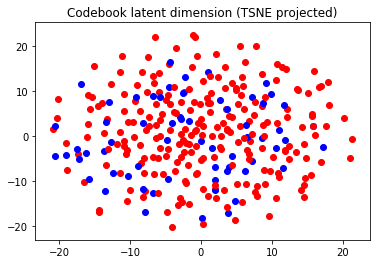

<Figure size 432x288 with 0 Axes>

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
data, labels = loader.generate()
data = wrapper_model.embedder(data)
data = wrapper_model.pos_enb(data).permute(1,0,2)
for_tsne = wrapper_model.encoder(inputs_embeds = data).last_hidden_state
for_tsne = torch.flatten(for_tsne, start_dim=1)

for i in range(19):
    data, new_labels = loader.generate()
    data = wrapper_model.embedder(data)
    data = wrapper_model.pos_enb(data).permute(1,0,2)
    adding_data = wrapper_model.encoder(inputs_embeds = data).last_hidden_state
    adding_data = torch.flatten(adding_data, start_dim=1)
    for_tsne = torch.cat((for_tsne, adding_data), 0)

    for new_label in new_labels:
        labels.append(new_label)
        
pca = PCA(n_components = 50, svd_solver = "full")
codebooks = pca.fit_transform(for_tsne.detach())
print("err")
codebooks = TSNE(2, perplexity = 10, n_iter = 1000, learning_rate = 50, init = "pca").fit_transform(codebooks)
print(codebooks.shape)
colors = ['r', 'b']
#colors = ['r', 'b']
plt.title("Codebook latent dimension (TSNE projected)")
for i in range(300):
    if labels[i] == 'normal sinus rhythm; normal ecg':
        plt.scatter(codebooks[i,0], codebooks[i,1], c="b")
    else:
        plt.scatter(codebooks[i,0], codebooks[i,1], c="r")
plt.show()
plt.clf()

In [13]:
# hyperparameters
epochs = 200
optimizer = torch.optim.Adam(decoder.parameters(), lr = 1e-3)
torch.autograd.set_detect_anomaly(True)

# pretrain decoder
for i in range(epochs):
    optimizer.zero_grad()
    outputs = decoder(input_ids = labels, attention_mask = mask, labels = labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    
    print(loss)

tensor(4.1484, grad_fn=<NllLossBackward>)
tensor(2.0997, grad_fn=<NllLossBackward>)
tensor(1.6969, grad_fn=<NllLossBackward>)
tensor(1.5104, grad_fn=<NllLossBackward>)
tensor(1.4406, grad_fn=<NllLossBackward>)
tensor(2.3128, grad_fn=<NllLossBackward>)
tensor(1.3836, grad_fn=<NllLossBackward>)
tensor(1.3576, grad_fn=<NllLossBackward>)
tensor(1.3643, grad_fn=<NllLossBackward>)
tensor(1.3027, grad_fn=<NllLossBackward>)
tensor(1.2690, grad_fn=<NllLossBackward>)
tensor(1.2295, grad_fn=<NllLossBackward>)
tensor(1.1668, grad_fn=<NllLossBackward>)
tensor(1.1084, grad_fn=<NllLossBackward>)
tensor(1.0823, grad_fn=<NllLossBackward>)
tensor(1.0506, grad_fn=<NllLossBackward>)
tensor(1.0428, grad_fn=<NllLossBackward>)
tensor(1.0318, grad_fn=<NllLossBackward>)
tensor(1.0076, grad_fn=<NllLossBackward>)
tensor(0.9918, grad_fn=<NllLossBackward>)
tensor(0.9692, grad_fn=<NllLossBackward>)
tensor(0.9561, grad_fn=<NllLossBackward>)
tensor(0.9261, grad_fn=<NllLossBackward>)
tensor(0.9124, grad_fn=<NllLossBac

tensor(0.2296, grad_fn=<NllLossBackward>)
tensor(0.2275, grad_fn=<NllLossBackward>)
tensor(0.2274, grad_fn=<NllLossBackward>)
tensor(0.2226, grad_fn=<NllLossBackward>)


In [19]:
# Full Model
# hyperparameters
epochs = 300
torch.cuda.empty_cache()
model = EncoderDecoderModel(encoder = encoder, decoder = decoder).to(device)

# define optimizers
#emb_opt = torch.optim.Adam(embedder.parameters(), lr = 1e-3)
enc_dec_opt = torch.optim.Adam(model.parameters(), lr = 1e-6)

# define encoder decoder

# train enc to end
for i in range(epochs):
    # zero out gradients for new iteration
    #emb_opt.zero_grad()
    enc_dec_opt.zero_grad()
    
    # get outputs and loss
    inp_emb = embedder(full_x).transpose(1, 0)
    outputs = model(inputs_embeds = inp_emb, decoder_input_ids = labels, decoder_attention_mask = mask, labels = labels)
    loss = outputs.loss
    
    #if i == 40:
    #    enc_dec_opt = torch.optim.Adam(model.parameters(), lr = 1e-4)
    #if i == 60:
    #    enc_dec_opt = torch.optim.Adam(model.parameters(), lr = 1e-5)
    #if i == 180:
    #    enc_dec_opt = torch.optim.Adam(model.parameters(), lr = 1e-6)
    #if i == 210:
    #    enc_dec_opt = torch.optim.Adam(model.parameters(), lr = 1e-7)
    
    # perform gradient descent
    print(loss)
    loss.backward()
    #emb_opt.step()
    enc_dec_opt.step()
    

tensor(0.3178, grad_fn=<NllLossBackward>)
tensor(0.3409, grad_fn=<NllLossBackward>)
tensor(0.3193, grad_fn=<NllLossBackward>)
tensor(0.3222, grad_fn=<NllLossBackward>)
tensor(0.3329, grad_fn=<NllLossBackward>)
tensor(0.3292, grad_fn=<NllLossBackward>)
tensor(0.3192, grad_fn=<NllLossBackward>)
tensor(0.3215, grad_fn=<NllLossBackward>)
tensor(0.3214, grad_fn=<NllLossBackward>)
tensor(0.3172, grad_fn=<NllLossBackward>)
tensor(0.3272, grad_fn=<NllLossBackward>)
tensor(0.3248, grad_fn=<NllLossBackward>)
tensor(0.3253, grad_fn=<NllLossBackward>)
tensor(0.3277, grad_fn=<NllLossBackward>)
tensor(0.3339, grad_fn=<NllLossBackward>)
tensor(0.3359, grad_fn=<NllLossBackward>)
tensor(0.3179, grad_fn=<NllLossBackward>)
tensor(0.3191, grad_fn=<NllLossBackward>)
tensor(0.3282, grad_fn=<NllLossBackward>)
tensor(0.3247, grad_fn=<NllLossBackward>)
tensor(0.3319, grad_fn=<NllLossBackward>)
tensor(0.3261, grad_fn=<NllLossBackward>)
tensor(0.3246, grad_fn=<NllLossBackward>)
tensor(0.3262, grad_fn=<NllLossBac

tensor(0.3171, grad_fn=<NllLossBackward>)
tensor(0.3275, grad_fn=<NllLossBackward>)
tensor(0.3126, grad_fn=<NllLossBackward>)
tensor(0.3226, grad_fn=<NllLossBackward>)
tensor(0.3264, grad_fn=<NllLossBackward>)
tensor(0.3286, grad_fn=<NllLossBackward>)
tensor(0.3195, grad_fn=<NllLossBackward>)
tensor(0.3213, grad_fn=<NllLossBackward>)
tensor(0.3261, grad_fn=<NllLossBackward>)
tensor(0.3224, grad_fn=<NllLossBackward>)
tensor(0.3213, grad_fn=<NllLossBackward>)
tensor(0.3228, grad_fn=<NllLossBackward>)
tensor(0.3317, grad_fn=<NllLossBackward>)
tensor(0.3174, grad_fn=<NllLossBackward>)
tensor(0.3226, grad_fn=<NllLossBackward>)
tensor(0.3258, grad_fn=<NllLossBackward>)
tensor(0.3261, grad_fn=<NllLossBackward>)
tensor(0.3241, grad_fn=<NllLossBackward>)
tensor(0.3249, grad_fn=<NllLossBackward>)
tensor(0.3181, grad_fn=<NllLossBackward>)
tensor(0.3293, grad_fn=<NllLossBackward>)
tensor(0.3186, grad_fn=<NllLossBackward>)
tensor(0.3261, grad_fn=<NllLossBackward>)
tensor(0.3150, grad_fn=<NllLossBac

In [27]:
inp_emb = embedder(full_x).transpose(1, 0)
print(inp_emb.shape)
model.generate(inputs_embeds = inp_emb)
    

torch.Size([52, 100, 256])


AttributeError: 'NoneType' object has no attribute 'new_ones'

In [48]:
torch.cuda.empty_cache()
